In [ ]:

import sys

print('{} -m pip install networkx --upgrade'.format(sys.executable))
!{sys.executable} -m pip install networkx --upgrade

In [1]:

%run ../../load_magic/storage.py
%run ../../load_magic/dataframes.py
%run ../../load_magic/environment.py
%pprint
pd.options.display.float_format = '{:20,.2f}'.format
notebook_path = get_notebook_path()
print(notebook_path)
s = Storage()
print(['s.{}'.format(fn) for fn in dir(s) if not fn.startswith('_')])
dir()

Pretty printing has been turned OFF
C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\ipynb\Untitled.ipynb
['s.attempt_to_pickle', 's.data_csv_folder', 's.data_folder', 's.encoding_type', 's.load_csv', 's.load_dataframes', 's.load_object', 's.save_dataframes', 's.saves_csv_folder', 's.saves_folder', 's.saves_pickle_folder', 's.store_objects']


['Config', 'In', 'Out', 'Storage', '_', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__nonzero__', '__package__', '__spec__', '_dh', '_i', '_i1', '_ih', '_ii', '_iii', '_oh', 'csv', 'example_iterrows', 'exit', 'get_column_descriptions', 'get_dir_tree', 'get_ipython', 'get_max_rsquared_adj', 'get_module_version', 'get_notebook_path', 'get_page_tables', 'ipykernel', 'json', 'jupyter_config_dir', 'math', 'notebook_path', 'notebookapp', 'os', 'pd', 'pickle', 'plt', 'quit', 's', 'sm', 'sns', 'stats', 'sys', 'urllib']

In [2]:

tables_url = r'https://docs.google.com/spreadsheets/d/11Ov1Y1xM-LCeYSSBYZ7yPXJah2ldgFX4oIlDtdd7-Qw'
tribes_df_list = get_page_tables(tables_url)

[(0, (35, 12)), (1, (1, 5))]


In [3]:

tribes_df = tribes_df_list[0].copy().dropna(axis=0, how='all').dropna(axis=1, how='all').iloc[:, 1:]
tribes_df.columns = tribes_df.iloc[0]
tribes_df = tribes_df.iloc[1:].T
tribes_df.columns = tribes_df.iloc[0]
tribes_df = tribes_df.iloc[1:].T
s.store_objects(tribes_df=tribes_df)
tribes_df.sample(3).T.sample(6).T

Pickling to C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\saves\pickle\tribes_df.pickle


,SACRED VALUES,TELOS,CAMPFIRE,CHIEFTAINS,MENTAL MODELS,COMBATANTS
MEMETIC TRIBE,,,,,,
Occupy,Economic Justice,Remove the 1% from power,"Protests, Student groups, zines","Kalle Lasn, Naomi Klein, David Graeber","The 99%, Culture Jamming, Crony Capitalism","Establishment Left, Establishment Right"
Establishment Left,"Equality, Progress",Achieve social and economic equality,"CNN, The New Yorker, Harvard","The Clintons, Barack Obama","Welfare state, Pro-choice, Gun Control","Establishment Right, DSA, Dirtbag Left"
QAnoners,Retribution,"""The Great Awakening""","/pol/, Reddit, twitter, rallies",Qanon,"The Storm, Double Meanings, Pedogate","Establishment Left, Establishment Right"


In [4]:

import networkx as nx

tribes_digraph = nx.DiGraph()
tribes_digraph.add_nodes_from(tribes_df.T.to_dict())

In [5]:

from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

tribe_list = tribes_df.index.tolist()
for row_index, row_value in tribes_df['COMBATANTS'].iteritems():
    combatant_list = row_value.split(', ')
    for combatant in combatant_list:
        if combatant != 'None':
            
            # The combatants are in slightly differing spellings,
            # so I need to just guess which one I mean
            this_tribe = sorted(tribe_list,
                                key=lambda tribe: similar(combatant, tribe.split(' (')[0]))[-1]
            
            tribes_digraph.add_edge(row_index, this_tribe)
s.store_objects(tribes_digraph=tribes_digraph)

Pickling to C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\saves\pickle\tribes_digraph.pickle


In [6]:

# Import the graph from Gephi
SAVES_FOLDER = '../saves/'
gexf_dir = os.path.join(SAVES_FOLDER, 'gexf')
file_name = 'tribes_digraph.gexf'
file_path = os.path.join(gexf_dir, file_name)

In [7]:

full_edge_list = list(tribes_digraph.edges())
double_edge_list = []
while len(full_edge_list) > 0:
    edge_tuple = full_edge_list.pop()
    doubled_tuple = (edge_tuple[1], edge_tuple[0])
    if doubled_tuple in full_edge_list:
        double_edge_list.append(edge_tuple)
        double_edge_list.append(doubled_tuple)

In [8]:

single_edge_list = []
full_edge_list = list(tribes_digraph.edges())
for edge_tuple in full_edge_list:
    if edge_tuple not in double_edge_list:
        single_edge_list.append(edge_tuple)

In [11]:

# Make fat arrows
arrowstyle = mpatches.ArrowStyle.Simple(head_length=2., head_width=1.5, tail_width=0.05)

In [ ]:

%run ../py/tribes_layout.py
print(tribal_layout_dict)
tribal_layout_dict = {}
for row_index, row_series in layout_df.iterrows():
    tribe_name = row_series['tribe_name']
    layout_x = row_series['layout_x']
    layout_y = row_series['layout_y']
    tribal_layout_dict[tribe_name] = np.array([float(layout_x), float(layout_y)])
print(tribal_layout_dict)

In [31]:

import xmltodict
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
%matplotlib inline

# Import from Gephi
with open(file_path, 'r') as fid:
    tribal_xml = fid.read()
tribal_tree = xmltodict.parse(tribal_xml)

# Get the position dictionary for the GEXF saved from Gephi
node_dict_list = tribal_tree['gexf']['graph']['nodes']['node']
tribal_layout_dict = {node_dict['@id']: np.array([float(node_dict['viz:position']['@x']),
                                                  float(node_dict['viz:position']['@y'])])
                      for node_dict in node_dict_list}

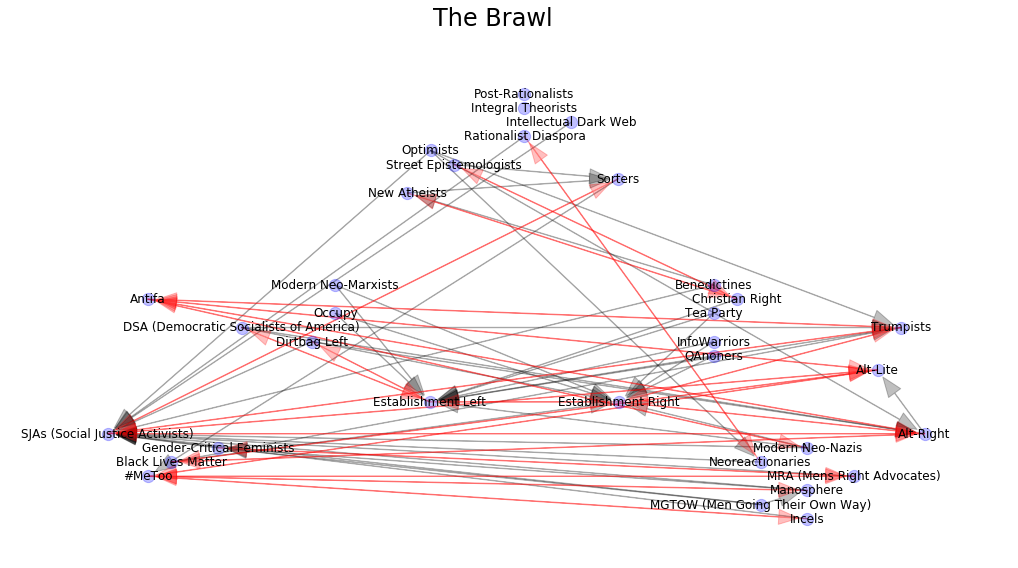

In [32]:

# Draw the graph using the gephi layout
tribal_fig = plt.figure(figsize=(18, 9))
ax = tribal_fig.add_subplot(111)
plt.axis('off')
plt.xticks([], [])
plt.yticks([], [])
tribal_fig.suptitle('The Brawl', fontsize=24)

# Make the nodes blue so you can make the double edges red
node_collection = nx.draw_networkx_nodes(G=tribes_digraph, pos=tribal_layout_dict, alpha=0.25,
                                         node_color='b', node_size=150)

# Get the double-edged edge list in red
edge_collection = nx.draw_networkx_edges(G=tribes_digraph, pos=tribal_layout_dict, alpha=0.25,
                                         arrowstyle=arrowstyle, edgelist=single_edge_list)
edge_collection = nx.draw_networkx_edges(G=tribes_digraph, pos=tribal_layout_dict, alpha=0.25,
                                         arrowstyle=arrowstyle, edgelist=double_edge_list,
                                         edge_color='r')
''''''

labels_collection = nx.draw_networkx_labels(G=tribes_digraph, pos=tribal_layout_dict, font_size=12)
axes_subplot = tribal_fig.get_axes()[0]
xlim_tuple = axes_subplot.set_xlim(left=-1500, right=1500)

In [28]:

import os

# Export the graph into Gephi
SAVES_FOLDER = '../saves/'
gexf_dir = os.path.join(SAVES_FOLDER, 'gexf')
os.makedirs(name=gexf_dir, exist_ok=True)
file_name = 'tribes_digraph.gexf'
file_path = os.path.join(gexf_dir, file_name)
nx.write_gexf(tribes_digraph, file_path)
message_str = '''
1) Launch Gephi
2) In the File menu, open {}
3) Select and run the Fruchterman Reingold layout
4) Select and run the Label Adjust layout
5) In the File/Export submenu, select Graph file... and overwrite the old {}
6) Repeat 2) through 5) as necessary
'''
print(message_str.format(os.path.abspath(file_path), file_name))


1) Launch Gephi
2) In the File menu, open C:\Users\dev\Documents\repositories\notebooks\Miscellaneous\saves\gexf\tribes_digraph.gexf
3) Select and run the Fruchterman Reingold layout
4) Select and run the Label Adjust layout
5) In the File/Export submenu, select Graph file... and overwrite the old tribes_digraph.gexf
6) Repeat 2) through 5) as necessary

